In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import pywt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from arch import arch_model

/Users/nuzzo2/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:

class TimeSeriesAnalyzer:
    def __init__(self):
        self.data = None
        self.pairs = None
        self.decompositions = {}
        
    def fetch_data(self, tickers, start='2018-01-01'):
        """Fetch financial data"""
        self.data = pd.DataFrame()
        for ticker in tickers:
            df = yf.download(ticker, start=start)
            self.data[ticker] = df['Adj Close']
        return self.data
    
    def wavelet_decomposition(self, series, wavelet='db1', level=4):
        """Perform wavelet decomposition"""
        coeffs = pywt.wavedec(series, wavelet, level=level)
        return coeffs
    
    def find_cointegrated_pairs(self, significance=0.05):
        """Find cointegrated pairs in the dataset"""
        n = len(self.data.columns)
        pvalues = np.ones((n, n))
        pairs = []
        
        for i in range(n):
            for j in range(i+1, n):
                stock1 = self.data.iloc[:, i]
                stock2 = self.data.iloc[:, j]
                result = coint(stock1, stock2)
                pvalues[i, j] = result[1]
                
                if result[1] < significance:
                    pairs.append((self.data.columns[i], 
                                self.data.columns[j], 
                                result[1]))
        
        self.pairs = pd.DataFrame(pairs, 
                                columns=['Stock1', 'Stock2', 'p-value'])
        return self.pairs
    
    def pairs_trading_signals(self, stock1, stock2, window=20):
        """Generate trading signals for cointegrated pairs"""
        # Price spread
        spread = self.data[stock1] - self.data[stock2]
        
        # Z-score
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std
        
        # Trading signals
        signals = pd.DataFrame(index=spread.index)
        signals['z_score'] = zscore
        signals['long_entry'] = zscore < -2.0
        signals['short_entry'] = zscore > 2.0
        signals['exit'] = abs(zscore) < 0.5
        
        return signals
    
    def neural_prophet_forecast(self, series, periods=30):
        """Forecast using NeuralProphet"""
        df = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })
        
        model = NeuralProphet(
            n_forecasts=periods,
            n_lags=10,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True
        )
        
        metrics = model.fit(df, freq='D')
        forecast = model.predict(df)
        return forecast
    
    def garch_volatility(self, returns):
        """Estimate volatility using GARCH"""
        model = arch_model(returns, vol='Garch', p=1, q=1)
        results = model.fit(disp='off')
        return results.conditional_volatility
    
    def plot_decomposition(self, series, coeffs, title):
        """Plot wavelet decomposition"""
        fig, axes = plt.subplots(len(coeffs), 1, figsize=(15, 3*len(coeffs)))
        for i, coef in enumerate(coeffs):
            axes[i].plot(coef)
            axes[i].set_title(f'Level {i}')
        plt.suptitle(title)
        plt.tight_layout()
        return fig
    
    def plot_pairs_analysis(self, stock1, stock2):
        """Plot pairs trading analysis"""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
        
        # Price series
        normalized1 = self.data[stock1] / self.data[stock1].iloc[0]
        normalized2 = self.data[stock2] / self.data[stock2].iloc[0]
        ax1.plot(normalized1, label=stock1)
        ax1.plot(normalized2, label=stock2)
        ax1.set_title('Normalized Prices')
        ax1.legend()
        
        # Spread
        spread = self.data[stock1] - self.data[stock2]
        ax2.plot(spread)
        ax2.set_title('Price Spread')
        
        # Trading signals
        signals = self.pairs_trading_signals(stock1, stock2)
        ax3.plot(signals['z_score'])
        ax3.axhline(y=2.0, color='r', linestyle='--')
        ax3.axhline(y=-2.0, color='r', linestyle='--')
        ax3.axhline(y=0, color='k', linestyle='-')
        ax3.set_title('Z-Score with Trading Signals')
        
        plt.tight_layout()
        return fig


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Cointegrated Pairs:
  Stock1 Stock2   p-value
0    XLV    XLP  0.023054


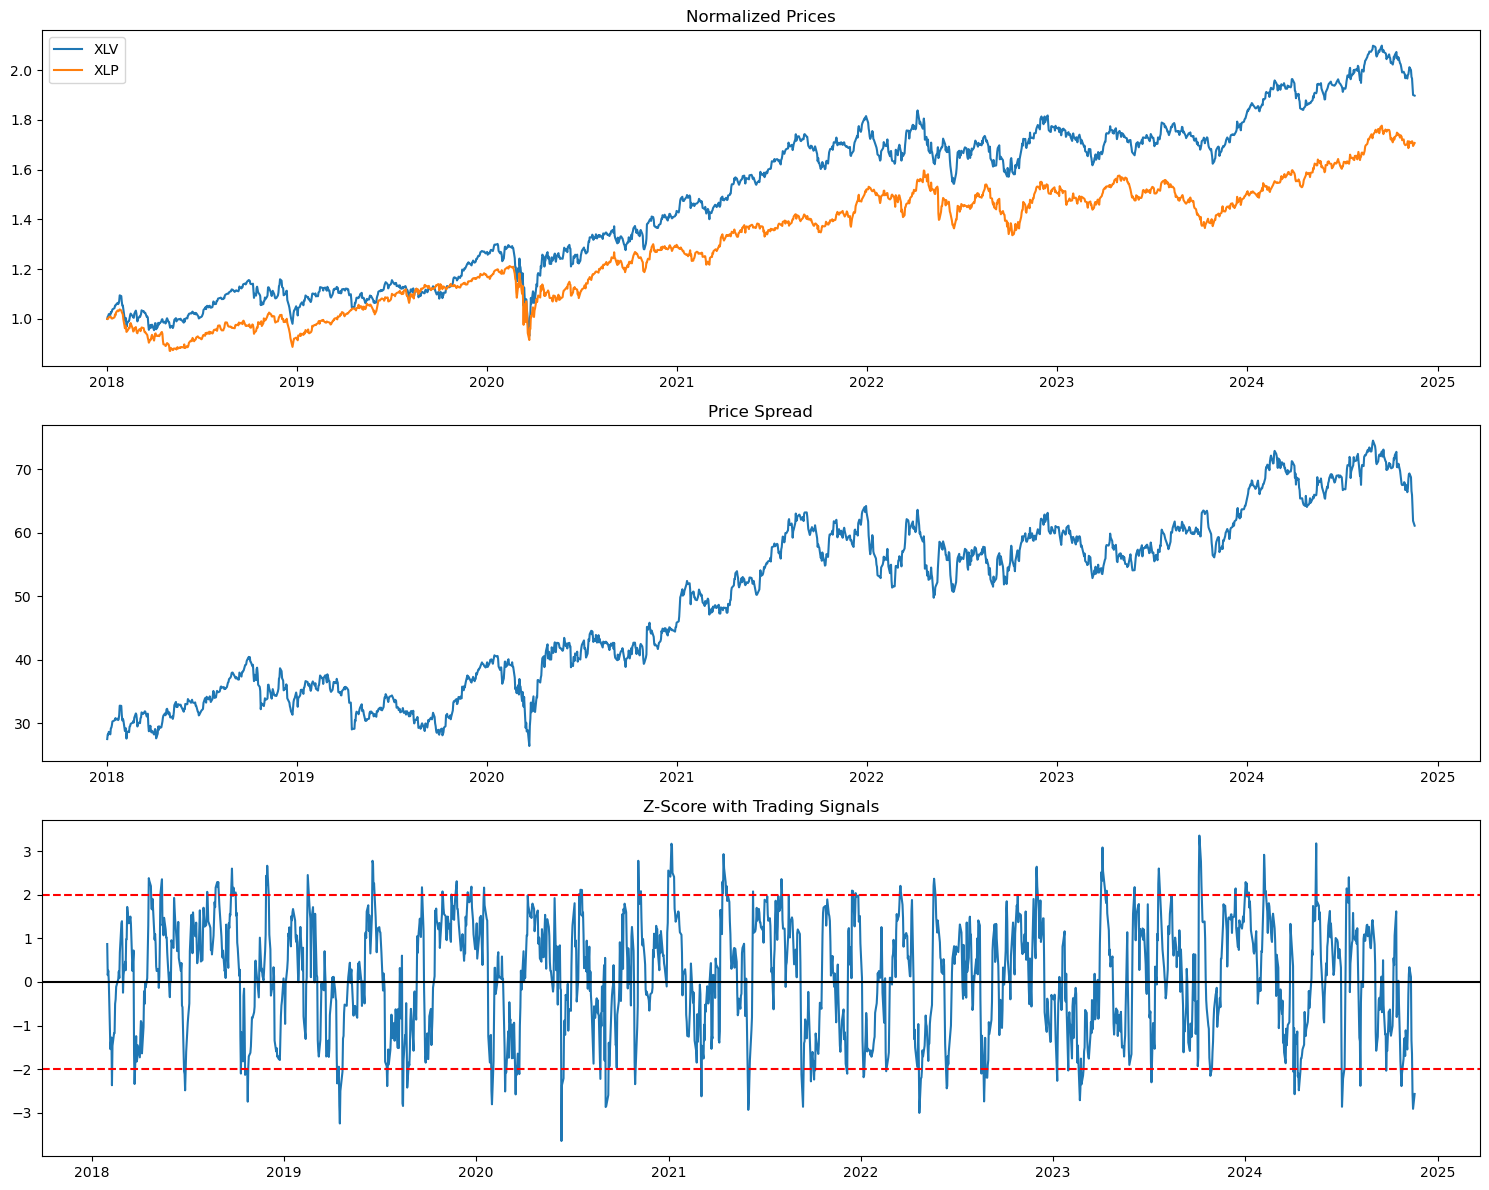

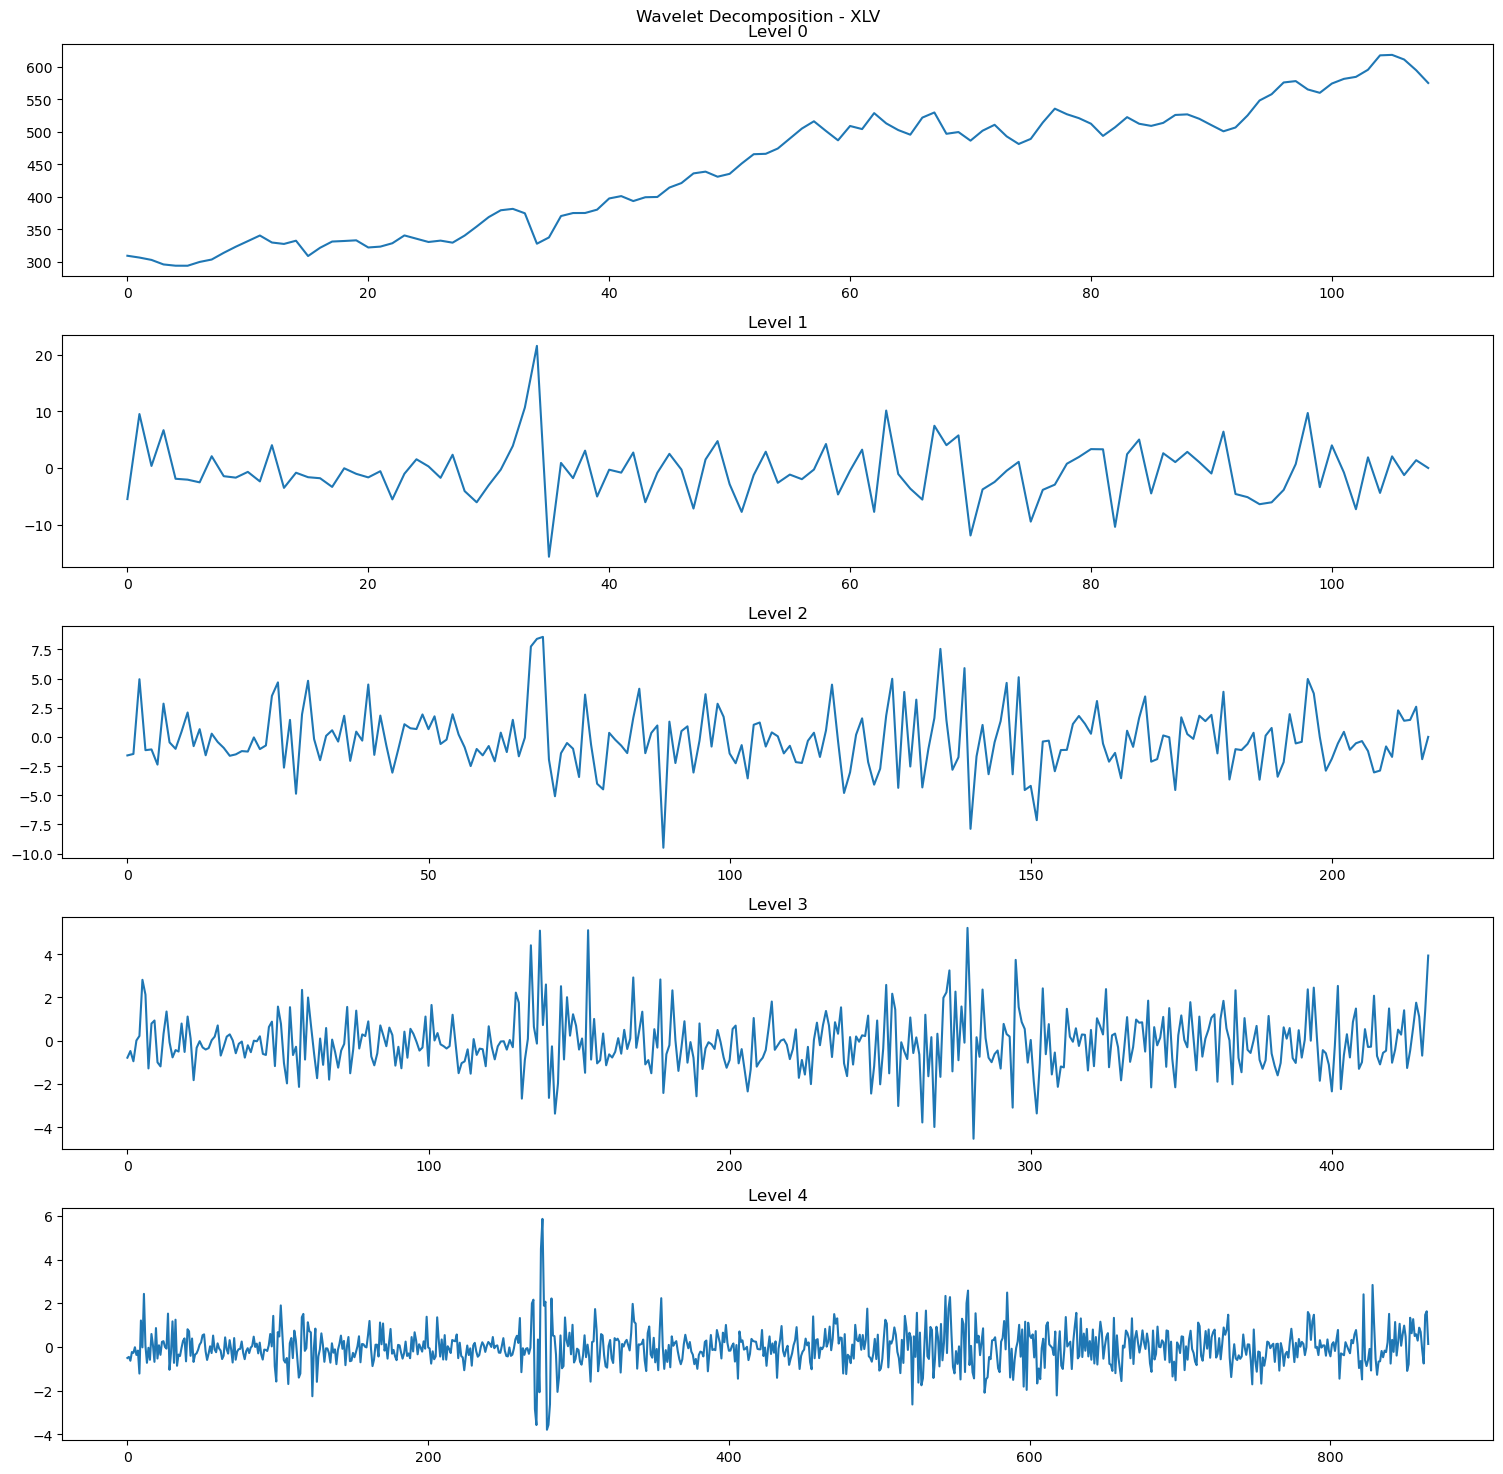

In [3]:

# Initialize analyzer
analyzer = TimeSeriesAnalyzer()

# Define universe
tickers = ['XLF', 'XLK', 'XLE', 'XLV', 'XLP']

# Fetch data
data = analyzer.fetch_data(tickers)

# Find cointegrated pairs
pairs = analyzer.find_cointegrated_pairs()
print("\nCointegrated Pairs:")
print(pairs)

# Analyze first pair if found
if not pairs.empty:
    stock1, stock2 = pairs.iloc[0][['Stock1', 'Stock2']]
    
    # Generate and plot trading signals
    signals = analyzer.pairs_trading_signals(stock1, stock2)
    analyzer.plot_pairs_analysis(stock1, stock2)
    plt.show()
    
    # Wavelet decomposition
    series = data[stock1]
    coeffs = analyzer.wavelet_decomposition(series)
    analyzer.plot_decomposition(series, coeffs, f'Wavelet Decomposition - {stock1}')
    plt.show()